<a href="https://colab.research.google.com/github/babuus/Machine-Learning/blob/master/Titanic_Dataset_acc_84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle #For downloading datasets
!pip install livelossplot #For displaying live plots of training

In [179]:
#Import functions
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import files
from livelossplot import PlotLossesKeras
from pandas_profiling import ProfileReport

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
#uploading Kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"babuus","key":"8d8c3864d8bc1568f7b7841b4a66314d"}'}

In [5]:
#Download dataset from kaggle
%%bash
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
mkdir Dataset
cd Dataset
kaggle competitions download -c titanic

mkdir: cannot create directory ‘Dataset’: File exists
100%|##########| 28.0k/28.0k [00:00<00:00, 10.9MB/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 4.03MB/s]
100%|##########| 59.8k/59.8k [00:00<00:00, 55.8MB/s]


In [276]:
train = pd.read_csv('/content/Dataset/train.csv')
test = pd.read_csv('/content/Dataset/test.csv')
sub = pd.read_csv('/content/Dataset/gender_submission.csv')
print("Train :",train.shape, "Test :", test.shape )
train.head()

Train : (891, 12) Test : (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [220]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [221]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [259]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [279]:
train1 = train.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], axis=1)
test1 = test.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], axis=1)
train1.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [280]:
train1.Age.fillna(train1.Age.median(), inplace = True)
test1.Age.fillna(test1.Age.median(), inplace = True)
test1.Fare.fillna(test1.Fare.median(), inplace = True)
# train1.Age_group.fillna(train1.Age_group.median(), inplace = True)

In [281]:
# We apply this equation.
def male_female_child(passenger):
    # Take the Age and Sex
    age,sex = passenger
    # Compare the age, otherwise leave the sex
    if (age < 16):
        return 'child'
    else:
        return sex
# We'll define a new column called 'person', remember to specify axis=1 for columns and not index
train1['person'] = train1[['Age','Sex']].apply(male_female_child,axis=1)
test1['person'] = test1[['Age','Sex']].apply(male_female_child,axis=1)
train1["person"].value_counts()

male      537
female    271
child      83
Name: person, dtype: int64

In [282]:
def age_groups(age):
    if age >= 65:
        return(6)#'65 or above'
    elif age > 55:
        return(5)#'56 - 65 years'
    elif age > 45:
        return(4)#'46 - 55 years'
    elif age > 35:
        return(3)#'36 - 45 years'
    elif age > 25:
        return(2)#'26 - 35 years'
    elif age > 18:
        return(1)#'19 - 25 years'
    elif age > 0:
        return(0)#'0 - 18 years'
    else:
        return(None)
train1['Age_group'] = train1['Age'].apply(age_groups)
train1['Alone'] =  train1.Parch + train1.SibSp
test1['Age_group'] = test1['Age'].apply(age_groups)
test1['Alone'] =  test1.Parch + test1.SibSp

In [283]:
def alone(passenger):
    sib,parch = passenger
    if sib ==0 and parch==0:
        return 0 #"alone"
    else:
        return 1 #"family"
train1['came_with'] = train1[["SibSp","Parch"]].apply(alone,axis=1)
test1['came_with'] = test1[["SibSp","Parch"]].apply(alone,axis=1)

In [284]:
train1["Embarked"].fillna("S", inplace=True)
test1["Embarked"].fillna("S", inplace=True)
# train1['Embarked'] = train1['Embarked'].astype(str)
train1["Embarked"].value_counts(), train1['Embarked'].dtypes

(S    646
 C    168
 Q     77
 Name: Embarked, dtype: int64, dtype('O'))

In [285]:
train2 = train1.drop(['Age','Sex'], axis=1)
test2 = test1.drop(['Age','Sex'], axis=1)

In [286]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   SibSp      891 non-null    int64  
 3   Parch      891 non-null    int64  
 4   Fare       891 non-null    float64
 5   Embarked   891 non-null    object 
 6   person     891 non-null    object 
 7   Age_group  891 non-null    int64  
 8   Alone      891 non-null    int64  
 9   came_with  891 non-null    int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 69.7+ KB


In [287]:
train2.head()

,Survived,Pclass,SibSp,Parch,Fare,Embarked,person,Age_group,Alone,came_with
0,0,3,1,0,7.2500,S,male,1,1,1
1,1,1,1,0,71.2833,C,female,3,1,1
2,1,3,0,0,7.9250,S,female,2,0,0
3,1,1,1,0,53.1000,S,female,2,1,1
4,0,3,0,0,8.0500,S,male,2,0,0


In [288]:
for i in train2:
    print(i, "--------------------",train2[i].unique())

Survived -------------------- [0 1]
Pclass -------------------- [3 1 2]
SibSp -------------------- [1 0 3 4 2 5 8]
Parch -------------------- [0 1 2 5 3 4 6]
Fare -------------------- [  7.25    71.2833   7.925   53.1      8.05     8.4583  51.8625  21.075
  11.1333  30.0708  16.7     26.55    31.275    7.8542  16.      29.125
  13.      18.       7.225   26.       8.0292  35.5     31.3875 263.
   7.8792   7.8958  27.7208 146.5208   7.75    10.5     82.1708  52.
   7.2292  11.2417   9.475   21.      41.5792  15.5     21.6792  17.8
  39.6875   7.8     76.7292  61.9792  27.75    46.9     80.      83.475
  27.9     15.2458   8.1583   8.6625  73.5     14.4542  56.4958   7.65
  29.      12.475    9.       9.5      7.7875  47.1     15.85    34.375
  61.175   20.575   34.6542  63.3583  23.      77.2875   8.6542   7.775
  24.15     9.825   14.4583 247.5208   7.1417  22.3583   6.975    7.05
  14.5     15.0458  26.2833   9.2167  79.2      6.75    11.5     36.75
   7.7958  12.525   66.6      7.312

In [289]:
for i in test2:
    print(i, "--------------------",test2[i].unique())

Pclass -------------------- [3 2 1]
SibSp -------------------- [0 1 2 3 4 5 8]
Parch -------------------- [0 1 3 2 4 6 5 9]
Fare -------------------- [  7.8292   7.       9.6875   8.6625  12.2875   9.225    7.6292  29.
   7.2292  24.15     7.8958  26.      82.2667  61.175   27.7208  12.35
   7.225    7.925   59.4      3.1708  31.6833  61.3792 262.375   14.5
  61.9792  30.5     21.6792  31.5     20.575   23.45    57.75     8.05
   9.5     56.4958  13.4167  26.55     7.85    13.      52.5542  29.7
   7.75    76.2917  15.9     60.      15.0333  23.     263.      15.5792
  29.125    7.65    16.1     13.5      7.725   21.       7.8792  42.4
  28.5375 211.5     25.7     15.2458 221.7792  10.7083  14.4542  13.9
   7.775   52.       7.7958  78.85     7.8542  55.4417   8.5167  22.525
   7.8208   8.7125  15.0458   7.7792  31.6792   7.2833   6.4375  16.7
  75.2417  15.75     7.25    23.25    28.5     25.4667  46.9    151.55
  18.      51.8625  83.1583  12.1833  31.3875   7.55    13.775    7.7333


In [290]:
le_Embarked_train = LabelEncoder()
train2['Embarked'] = le_Embarked_train.fit_transform(train2['Embarked'])
le_person_train = LabelEncoder()
train2['person'] = le_person_train.fit_transform(train2['person'])

le_Embarked_test = LabelEncoder()
test2['Embarked'] = le_Embarked_test.fit_transform(test2['Embarked'])
le_person_test = LabelEncoder()
test2['person'] = le_person_test.fit_transform(test2['person'])

In [ ]:
scaler = MinMaxScaler()
train3 = scaler.fit_transform(train2)
train3 = pd.DataFrame(train3, columns= train2.columns)

test3 = scaler.fit_transform(test2)
test3 = pd.DataFrame(test3, columns= test2.columns)

train3.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,1.0,1.0,0.271174,0.125,0.0,0.014151,1.0
1,1.0,0.0,0.0,0.472229,0.125,0.0,0.139136,0.0
2,1.0,1.0,0.0,0.321438,0.000,0.0,0.015469,1.0
3,1.0,0.0,0.0,0.434531,0.125,0.0,0.103644,1.0
4,0.0,1.0,1.0,0.434531,0.000,0.0,0.015713,1.0


In [273]:
X = train3.drop('Survived', axis=1)
y = train3['Survived']
X.head()

,Pclass,SibSp,Parch,Fare,Embarked,person,Age_group,Alone,came_with
0,1.0,0.125,0.0,0.014151,1.0,1.0,0.166667,0.1,1.0
1,0.0,0.125,0.0,0.139136,0.0,0.5,0.500000,0.1,1.0
2,1.0,0.000,0.0,0.015469,1.0,0.5,0.333333,0.0,0.0
3,0.0,0.125,0.0,0.103644,1.0,0.5,0.333333,0.1,1.0
4,1.0,0.000,0.0,0.015713,1.0,1.0,0.333333,0.0,0.0


In [235]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 9), (179, 9), (712,), (179,))

In [236]:
model = keras.Sequential()

#Input Layer
model.add(keras.layers.Dense(X.shape[1], activation='relu', input_shape = (9,)))

#Hidden Layer
model.add(keras.layers.Dense(26, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

#Output Layer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

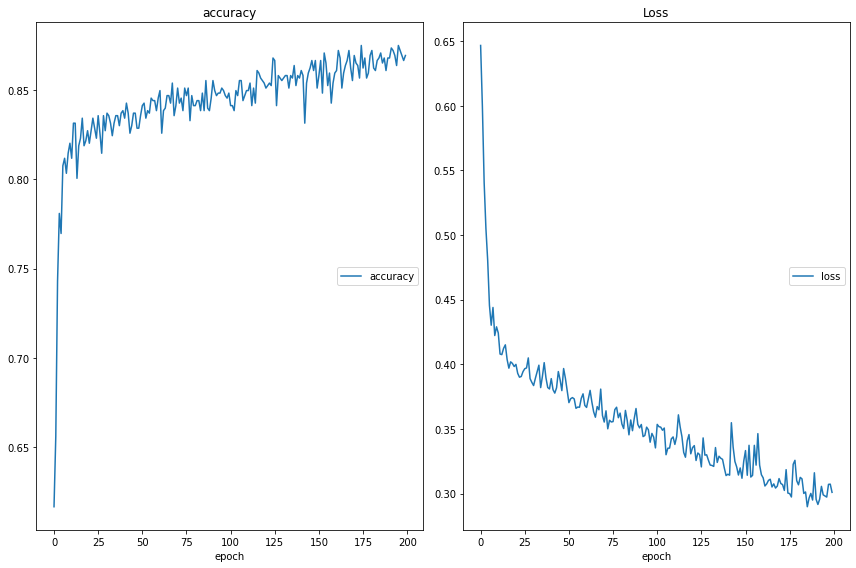

accuracy
	accuracy         	 (min:    0.617, max:    0.875, cur:    0.869)
Loss
	loss             	 (min:    0.290, max:    0.647, cur:    0.301)


In [237]:
history = model.fit(X_train, y_train, callbacks=[PlotLossesKeras()], epochs=200)

In [239]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.6068 - accuracy: 0.8156


[0.6067898869514465, 0.8156424760818481]

In [248]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve

classifier = svm.SVC(kernel='linear', gamma='auto', C=2)
classifier.fit(X_train,y_train)

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

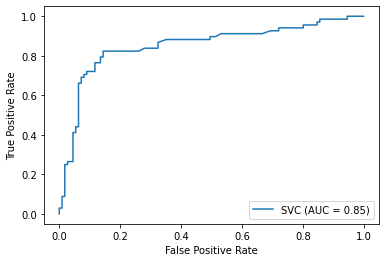

In [245]:
prd = classifier.predict(X_test)
plot_roc_curve(classifier, X_test, y_test)

In [249]:
classifier.score(X_test, y_test)

0.8379888268156425

In [251]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [274]:
logisticRegr.score(X_test, y_test)

0.8268156424581006

In [309]:
pred = model.predict(test3)
sub['Survived'] = np.round(pred).astype(int)
sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [310]:
sub['Survived'].unique()

array([0, 1])

In [311]:
sub.Survived.value_counts()

0    272
1    146
Name: Survived, dtype: int64

In [312]:
sub.to_csv('submission.csv', index=False)

In [313]:
!kaggle competitions submit -c titanic -f submission.csv -m "ANN"

100% 2.77k/2.77k [00:00<00:00, 7.77kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster